In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot  as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("./04_hashed.csv")

dataset.columns

Index(['Rdate', 'src_ip', 'dst_ip', 'Proto', 'src_port', 'dst_port', 'Action',
       'src_country', 'dst_country'],
      dtype='object')

In [3]:
# Rdate의 중복시간제거
unique_time = dataset['Rdate'].unique()

print(len(unique_time))

24218


In [4]:
""" 
IPv4 ,각 그룹을 균등화하고 길이가 일치하도록 0 추가 
""" 
def transform_ip(ip): 
  IPV4_GROUP_LENGTH = 3 # IPv4의 각 그룹은 이 길이입니다.
  # IPv4 주소 
  groups = ip.split( "." ) 
  equalize_group_length = "".join( map( lambda group: group.zfill(3), groups )) 
  return equalize_group_length 

"""
Converts the ipAddress column of pandas DataFrame df, to one-hot
Also returns the encoder used
"""
from sklearn.preprocessing import OneHotEncoder

def one_hot_ip(df):
  df['src_ip'] = df.src_ip.apply(lambda ip : transform_ip(ip))
  df['dst_ip'] = df.dst_ip.apply(lambda ip : transform_ip(ip))
  return df

In [5]:
feature = one_hot_ip(dataset)

In [6]:
# src_country / dst_country 를 사용하는 경우 
def labelEncoder(dataset):
  from sklearn.preprocessing import LabelEncoder
  job_encode = LabelEncoder()
  dataset['src_country'] = job_encode.fit_transform(dataset['src_country'])
  dataset['dst_country'] = job_encode.fit_transform(dataset['dst_country'])
  
  return dataset

In [7]:
feature_ = labelEncoder(feature)

In [14]:
# #############################################################################
# Compute DBSCAN
def dbscan(feature_, min_samples, eps):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    # 사용할 feature 선정 
    feature = feature_[ ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'Action']]
    scaler.fit(feature)
    feature_trans = scaler.transform(feature)
    print(feature_trans)
    # 파라미터 변경 
    model = DBSCAN(eps=eps, min_samples=min_samples)
    predict_label = model.fit_predict(feature_trans)
    predict = pd.DataFrame(predict_label)

    predict.columns = ['predict']
    predict.sort_values(by=['predict'])
    predict_unique = predict['predict'].unique()
    predict_unique.sort()
    print(predict_unique)
    r = pd.concat([feature_,predict],axis=1)

    labels = model.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Dataset Size : ",len(feature))
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    return r, labels, predict_label, predict_unique, feature_trans

In [15]:
# draw
def pair_plot(r):
  sns.pairplot(r,hue='predict')
  plt.show()


[[ 0.02476877 -0.42861806  0.17874798 -0.18618106  0.83313925]
 [ 0.02476877 -0.07300035  0.78273569 -0.18618106  0.83313925]
 [ 0.02476877 -0.20207622  1.03842015 -0.18618106  0.83313925]
 ...
 [ 0.02476877 -1.56777909  0.3499119  -0.18618106  0.83313925]
 [ 0.67617145 -0.93200802  0.47987697  8.15465719  0.83313925]
 [ 0.02476877 -2.03965206  0.95389961 -0.18618106  0.83313925]]
[-1  0  1  2  3  4  5  6  7]
Dataset Size :  23157
Estimated number of clusters: 8
Estimated number of noise points: 58


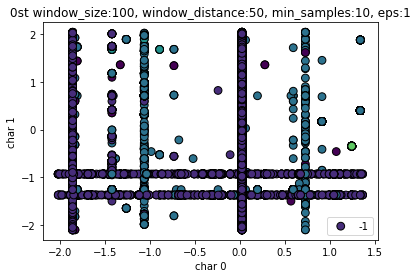


[[-0.01214724  1.03715156 -0.01266129 -0.18112809  0.88549532]
 [-0.01214724  1.20204722 -0.01258505 -0.18112809  0.88549532]
 [-0.01214724  0.29814135 -0.01243258 -0.18112809  0.88549532]
 ...
 [-0.24933292 -0.94661373 -0.6031737   0.91397532  0.88549532]
 [ 0.2404295  -0.94661373 -3.81386579  5.4306905   0.88549532]
 [-0.01214724 -0.04643208  0.45633334 -0.18112809  0.88549532]]


KeyboardInterrupt: 

In [16]:
# !pip install mglearn
import mglearn
import matplotlib.pyplot as plt

# window size 만큼의의 데이터 추출
window_size = 100
window_distance = 50
min_samples = 10 # 군집 최소 개수
eps = 1 # 반지름 길이
dbscan_final = pd.DataFrame()
for i in range(0,len(unique_time)-window_size,window_distance):
    window_df = pd.DataFrame()
    for j in range(window_size):
    # 특정시간대의 데이터만 추출
        select_time = feature_[feature_['Rdate']==unique_time[i+j]]
        window_df = pd.concat([window_df,select_time])

    # 추출된 특정시간대의 데이터만가지고 DBSCAN 진행
    dbscan_result,labels, predict_label, predict_unique, feature_trans = dbscan(window_df, min_samples, eps)
    anomaly_data = dbscan_result[dbscan_result['predict']==-1]
    dbscan_final = pd.concat([anomaly_data,dbscan_final])

    
    plt.scatter(feature_trans[:, 0], feature_trans[:, 1], c=predict_label, s=60, edgecolors='black')
    plt.xlabel("char 0")
    plt.ylabel("char 1")
    plt.title(f'{int(i/window_distance)}st window_size:{window_size}, window_distance:{window_distance}, min_samples:{min_samples}, eps:{eps}')
    plt.legend(predict_unique, ncol = len(predict_unique))
    plt.show()
    print()
    # pair_plot(dbscan_result)
